In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import joblib

## ⚙️ **Processamento** ⚙️

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Spark/Telco-Churn.csv')

In [ ]:
print(df.head().to_string())

In [ ]:
# Transformações essenciais para o funcionamento
df["Churn"] =            df["Churn"].map({"No": 0, "Yes": 1})
df["PhoneService"] =     df["PhoneService"].map({"No": 0, "Yes": 1})
df["MultipleLines"] =    df["MultipleLines"].map({"No": 0, "Yes": 1, "No phone service": 0})
df["InternetService"] =  df["InternetService"].map({"No": 0, "Fiber optic": 1, "DSL": 1})
df["OnlineSecurity"] =   df["OnlineSecurity"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["OnlineBackup"] =     df["OnlineBackup"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["DeviceProtection"] = df["DeviceProtection"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["TechSupport"] =      df["TechSupport"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["StreamingTV"] =      df["StreamingTV"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["StreamingMovies"] =  df["StreamingMovies"].map({"No": 0, "Yes": 1, "No internet service": 0})
df["PaymentMethod"] =    df["PaymentMethod"].map({"Electronic check": 0, "Mailed check": 1, "Bank transfer (automatic)": 2, "Credit card (automatic)": 3})
df["Contract"] =         df["Contract"].map({"Month-to-month": 0, "One year": 1, "Two year": 2})
df['TotalCharges'] =     pd.to_numeric(df['TotalCharges'].str.strip(), errors='coerce')
df["Mes"] = 73 - df["tenure"]

## ⏳ **Histórico** ⏳

In [ ]:
# Histograma - Entrada de clientes por mês
plt.figure(figsize=(8, 6))
plt.hist(df['Mes'], bins=50, color='green', alpha=0.8)
plt.title('Histograma - Entrada de clientes')
plt.xlabel('Mês')
plt.xticks(ticks=range(0, int(df['Mes'].max())+10, 10))
plt.ylabel('Novos Clientes')
plt.grid(True)
plt.show()

print((df['Mes']==71).sum())

# 📈 **Modelos e Aplicação** 📈

## 💸 **Quanto um cliente vai ter gasto com o passar dos meses** 💸

In [ ]:
# Treinando modelo de regressão linear para prever quanto um cliente vai ter gasto com o passar dos meses
df = df.dropna(subset=['TotalCharges'])

# Definir variáveis preditoras (X) e alvo (Y)
X = df[['tenure']]  # Preditor
Y = df['TotalCharges']  # Prever

# Dividir dados: Treinamento e Teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Criar e treinar modelo - Regressão Linear
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, Y_train)

# Prever valores de teste
Y_prev = modelo_lr.predict(X_test)

# Métricas de avaliação
r2 = r2_score(Y_test, Y_prev)
print(f'Coeficiente de Determinação - R²: {r2:.2f}')

# Calcular RMSE corretamente
rmse = mean_squared_error(Y_test, Y_prev)
print(f'Raiz do Erro Quadrático Médio - RMSE: {rmse:.2f}')
print(f'Desvio Padrão do campo TotalCharges: {df["TotalCharges"].std():.2f}')

In [ ]:
# Salvar modelo treinado - mudar o local de salvamento de acordo com a necessidade
joblib.dump(modelo_lr, filename='/content/drive/MyDrive/Colab Notebooks/Output/modelo_gasto_cliente.pkl')

In [ ]:
# Aplicando o modelo treinado - mudar o local de acesso de acordo com a necessidade
modelo_carregado = joblib.load('/content/drive/MyDrive/Colab Notebooks/Output/modelo_gasto_cliente.pkl')
mes_de_previsao = pd.DataFrame({
    'tenure': [60]
})
val_previsto = modelo_carregado.predict(mes_de_previsao)
print(np.round(val_previsto))

[4383.]


## 💰 **Previsão de Faturamento Mensal** 💰

In [ ]:
# Faturamento Mensal - Agrupar por "Mes" e somar os "MonthlyCharges"
soma_por_mes = df.groupby("Mes")["MonthlyCharges"].sum().sort_index()

# Fazer a soma acumulada
soma_acumulada = soma_por_mes.cumsum()

# Criar novo DataFrame
df_faturamento = pd.DataFrame({
    "Mes": soma_acumulada.index,
    "Faturamento": soma_acumulada.values
})

# Visualizar
print(df_faturamento.head())

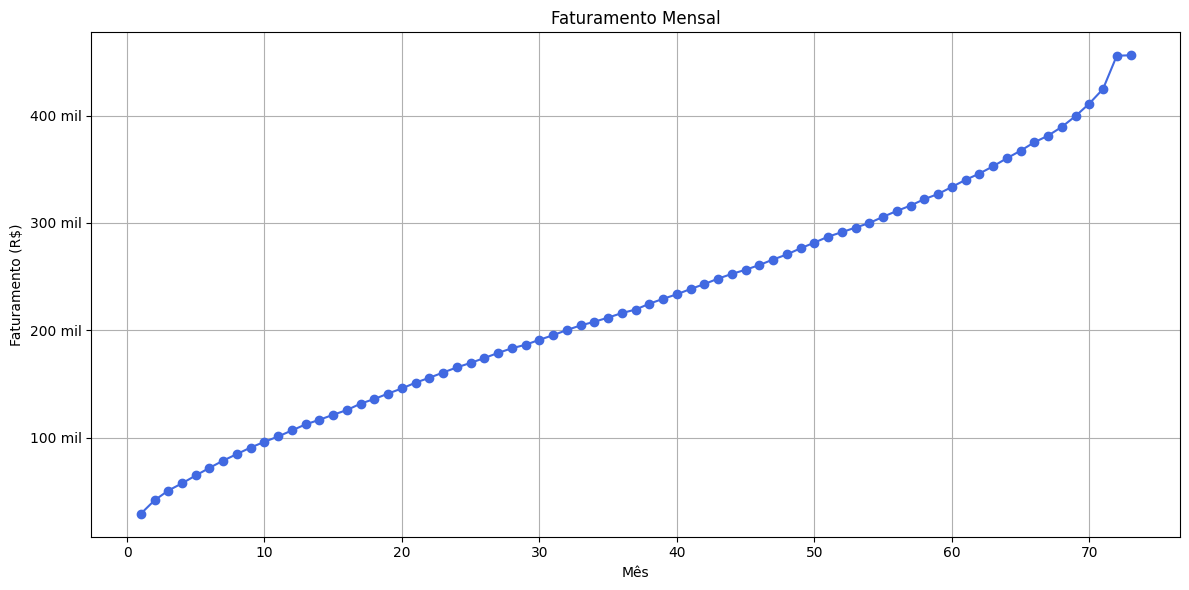

In [ ]:
# Gráfico de faturamento Mensal - execute a célula anterior antes
# Função para formatar os valores em "mil"
def em_mil(x, pos):
    return f'{int(x/1000)} mil'

plt.figure(figsize=(12, 6))
plt.plot(df_faturamento["Mes"], df_faturamento["Faturamento"], marker='o', color='royalblue')
plt.title("Faturamento Mensal")
plt.xlabel("Mês")
plt.ylabel("Faturamento (R$)")

# Aplicar formatação no eixo Y
plt.gca().yaxis.set_major_formatter(FuncFormatter(em_mil))

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Relação entre Faturamento e Mes
plt.figure(figsize=(5, 5))
corr = df_faturamento[['Mes', 'Faturamento']].corr()
print(corr)

In [ ]:
# Treinando modelo de regressão linear para prever o faturamento dos próximos meses

# Definir variáveis preditoras (X) e alvo (Y)
X = df_faturamento[['Mes']]  # Preditor
Y = df_faturamento['Faturamento']  # Prever

# Dividir dados: Treinamento e Teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Criar e treinar modelo - Regressão Linear
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, Y_train)

# Prever valores de teste
Y_prev = modelo_lr.predict(X_test)

# Métricas de avaliação
r2 = r2_score(Y_test, Y_prev)
print(f'Coeficiente de Determinação - R²: {r2:.2f}')

# Calcular RMSE corretamente
rmse = mean_squared_error(Y_test, Y_prev)
print(f'Raiz do Erro Quadrático Médio - RMSE: {rmse:.2f}')
print(f'Desvio Padrão do campo Faturamento: {df_faturamento["Faturamento"].std():.2f}')

In [ ]:
# Salvar modelo treinado - mudar o local de salvamento de acordo com a necessidade
joblib.dump(modelo_lr, filename='/content/drive/MyDrive/Colab Notebooks/Output/modelo_faturamento.pkl')

In [ ]:
# Aplicando o modelo treinado - mudar o local de acesso de acordo com a necessidade
modelo_carregado = joblib.load('/content/drive/MyDrive/Colab Notebooks/Output/modelo_faturamento.pkl')
mes_de_previsao = pd.DataFrame({
    'Mes': [59]
})
val_previsto = modelo_carregado.predict(mes_de_previsao)
print(np.round(val_previsto))